In [9]:
# Importar bibliotecas essenciais
import kagglehub # Para carregar datasets do Kaggle Hub
import pandas as pd # Para trabalhar com DataFrames
from kagglehub import KaggleDatasetAdapter # Adaptador para carregar com Pandas
import matplotlib.pyplot as plt # Para criar visualizações estáticas
import seaborn as sns # Para visualizações estatísticas mais atraentes
from sklearn.preprocessing import StandardScaler # Para escalonar os dados (pré-processamento)
from sklearn.model_selection import train_test_split # Para divisão de dados
from sklearn.ensemble import RandomForestClassifier # Para o modelo Random Forest
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, ConfusionMatrixDisplay # Métricas de avaliação
from imblearn.over_sampling import SMOTE # Para lidar com o desbalanceamento (oversampling)
import os # Para operações no sistema de arquivos, como criar diretórios
import numpy as np # Para operações numéricas

# --- Carregamento do Dataset Combinado Diretamente do Kaggle Hub ---
# Define o caminho do dataset no Kaggle Hub e o nome do arquivo CSV específico
wine_dataset_slug = "ruthgn/wine-quality-data-set-red-white-wine"
wine_file_name = "wine-quality-white-and-red.csv"

# Carrega o arquivo CSV diretamente para um DataFrame do Pandas
df_raw_combined_wine = kagglehub.load_dataset(
    KaggleDatasetAdapter.PANDAS,
    wine_dataset_slug,
    wine_file_name
)

# --- Salvando para Parquet (Boa prática para reusabilidade e performance) ---
output_dir = "data/processed"
os.makedirs(output_dir, exist_ok=True)
parquet_path = os.path.join(output_dir, "wine-quality-combined.parquet")

df_raw_combined_wine.to_parquet(parquet_path, engine="pyarrow", index=False)
print(f"DataFrame salvo com sucesso em formato Parquet: {parquet_path}")

C:\Users\albet\AppData\Local\Temp\ipykernel_20668\9055804.py:21: DeprecationWarning: load_dataset is deprecated and will be removed in a future version.
  df_raw_combined_wine = kagglehub.load_dataset(


DataFrame salvo com sucesso em formato Parquet: data/processed\wine-quality-combined.parquet


In [10]:
# --- Carrega o DataFrame a partir do arquivo Parquet processado ---
df_wine = pd.read_parquet(parquet_path)

print("\n--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet) ---")
print(df_wine.head())

print("\n--- Informações gerais do DataFrame principal ---")
df_wine.info()

print("\n--- Verificando valores ausentes no DataFrame principal ---")
print(df_wine.isnull().sum())


--- Primeiras 5 linhas do DataFrame principal (carregado do Parquet) ---
    type  fixed acidity  volatile acidity  citric acid  residual sugar  \
0  white            7.0              0.27         0.36            20.7   
1  white            6.3              0.30         0.34             1.6   
2  white            8.1              0.28         0.40             6.9   
3  white            7.2              0.23         0.32             8.5   
4  white            7.2              0.23         0.32             8.5   

   chlorides  free sulfur dioxide  total sulfur dioxide  density    pH  \
0      0.045                 45.0                 170.0   1.0010  3.00   
1      0.049                 14.0                 132.0   0.9940  3.30   
2      0.050                 30.0                  97.0   0.9951  3.26   
3      0.058                 47.0                 186.0   0.9956  3.19   
4      0.058                 47.0                 186.0   0.9956  3.19   

   sulphates  alcohol  quality  
0  

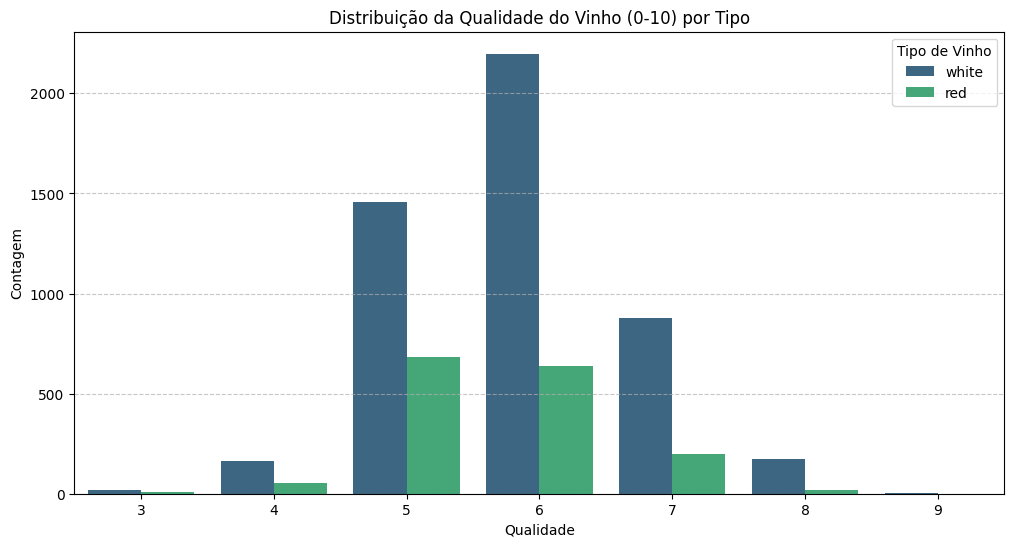


--- Contagem de cada nível de qualidade por tipo de vinho ---
type   quality
red    3            10
       4            53
       5           681
       6           638
       7           199
       8            18
white  3            20
       4           163
       5          1457
       6          2198
       7           880
       8           175
       9             5
Name: count, dtype: int64


In [11]:
# --- 2.1 Distribuição da Qualidade Original por Tipo de Vinho (EDA) ---
plt.figure(figsize=(12, 6))
sns.countplot(x='quality', data=df_wine, hue='type', palette='viridis')
plt.title('Distribuição da Qualidade do Vinho (0-10) por Tipo')
plt.xlabel('Qualidade')
plt.ylabel('Contagem')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend(title='Tipo de Vinho')
plt.show()

print("\n--- Contagem de cada nível de qualidade por tipo de vinho ---")
print(df_wine.groupby('type')['quality'].value_counts().sort_index())

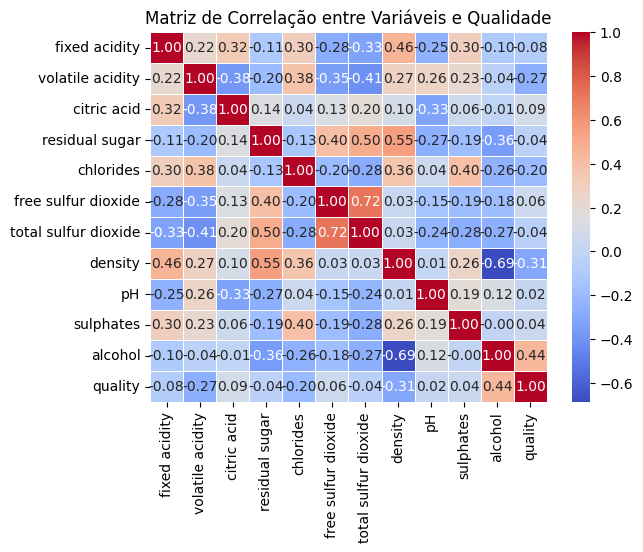


--- Correlações das variáveis físico-químicas com a Qualidade ---
quality                 1.000000
alcohol                 0.444319
citric acid             0.085532
free sulfur dioxide     0.055463
sulphates               0.038485
pH                      0.019506
residual sugar         -0.036980
total sulfur dioxide   -0.041385
fixed acidity          -0.076743
chlorides              -0.200666
volatile acidity       -0.265699
density                -0.305858
Name: quality, dtype: float64


In [12]:
# --- 2.2 Correlações com a Qualidade (EDA) ---
correlation_matrix = df_wine.drop('type', axis=1).corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação entre Variáveis e Qualidade')
plt.show()

print("\n--- Correlações das variáveis físico-químicas com a Qualidade ---")
print(correlation_matrix['quality'].sort_values(ascending=False))

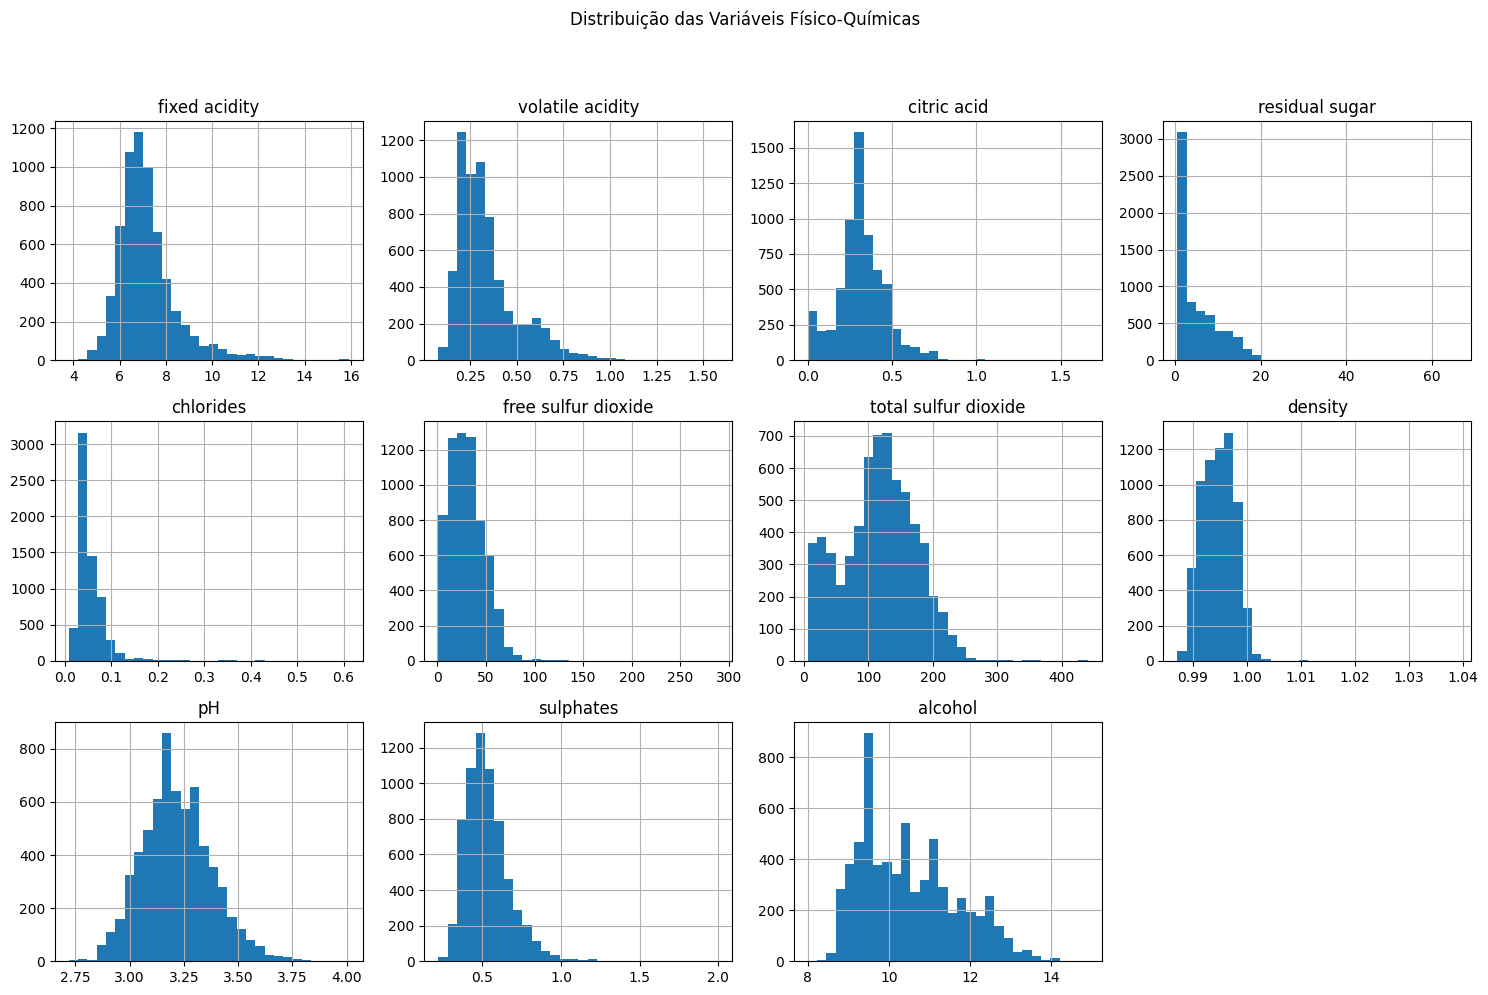

C:\Users\albet\AppData\Local\Temp\ipykernel_20668\1579420284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_20668\1579420284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Temp\ipykernel_20668\1579420284.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
C:\Users\albet\AppData\Local\Te

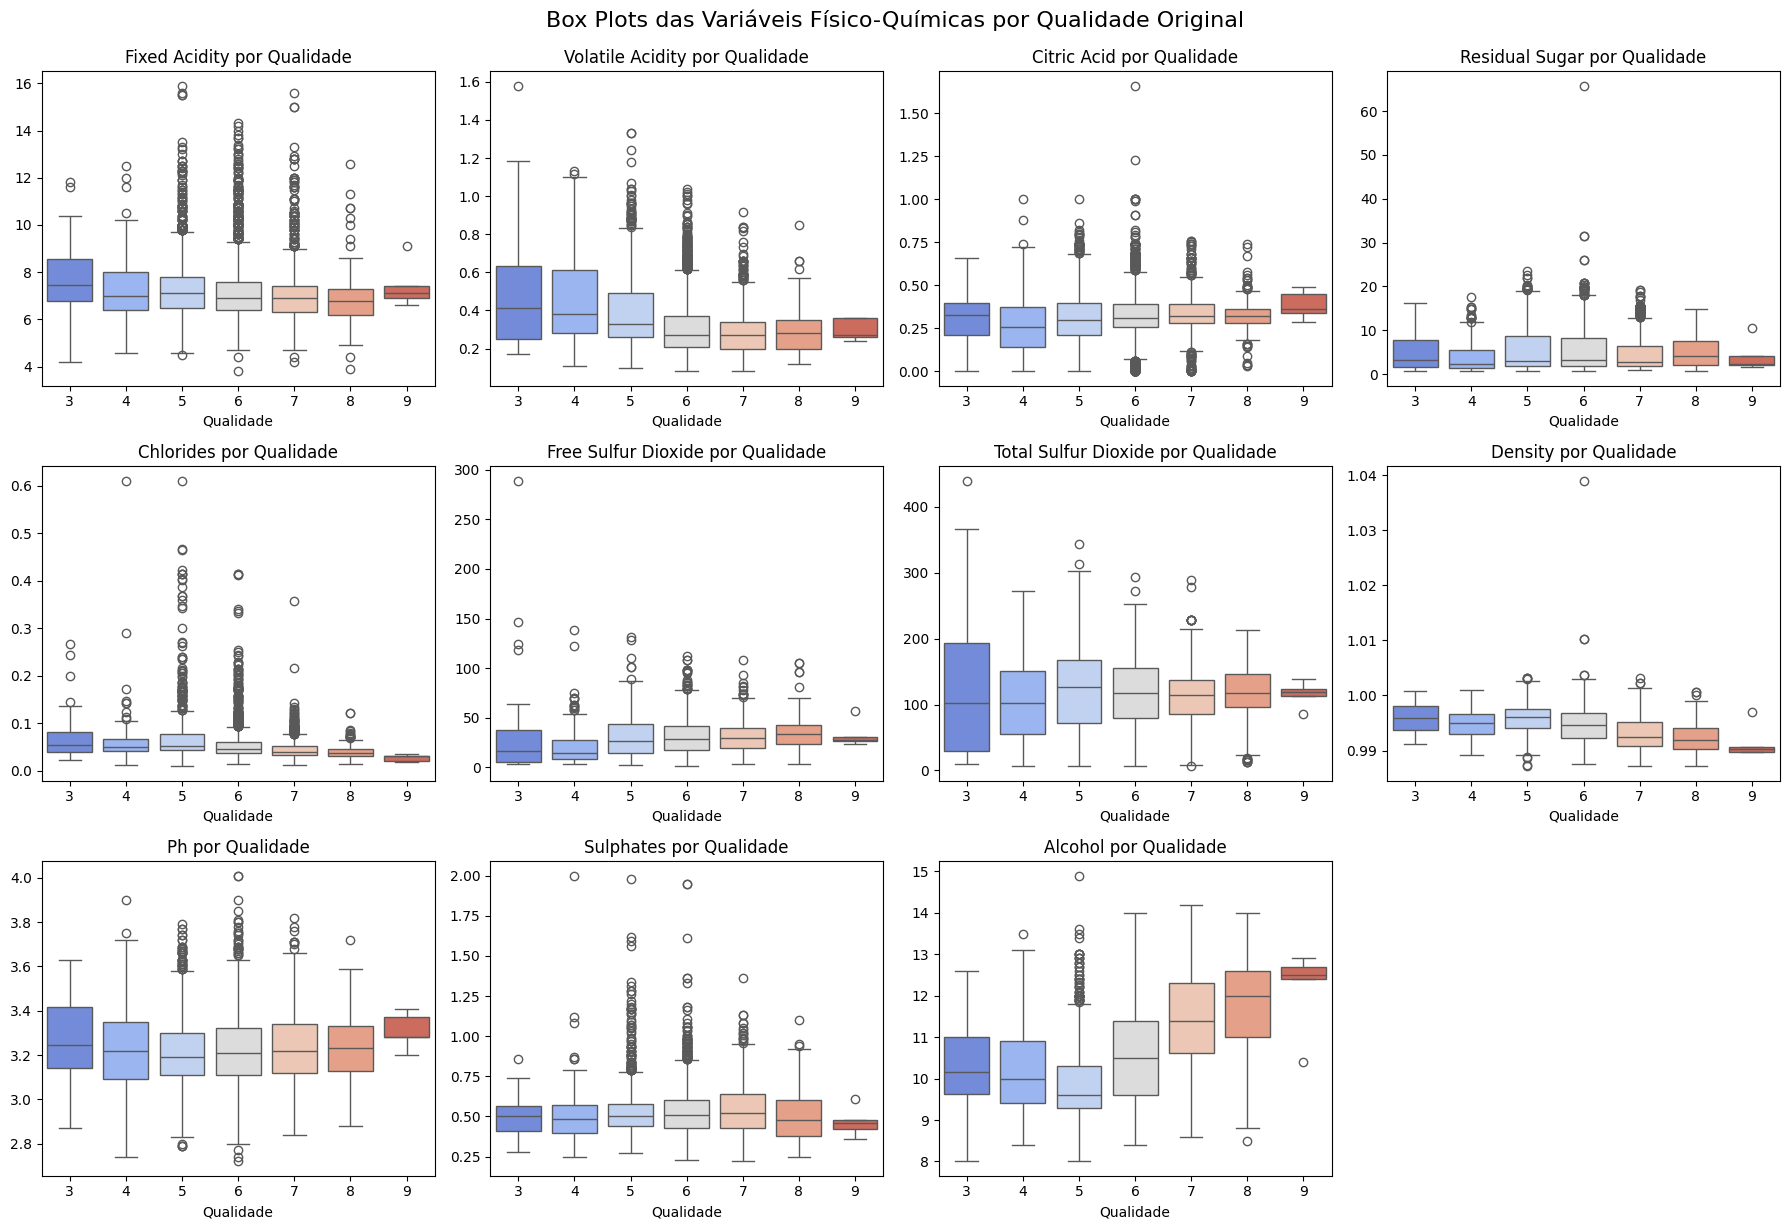

In [13]:
# --- 2.3 Distribuição das Variáveis Físico-Químicas (EDA) ---
df_wine.drop(['quality', 'type'], axis=1).hist(bins=30, figsize=(15, 10), layout=(3, 4))
plt.suptitle('Distribuição das Variáveis Físico-Químicas', y=1.02)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

# Boxplot para Outliers e Comparação por Qualidade
plt.figure(figsize=(18, 12))
features_to_plot_orig = df_wine.drop(['quality', 'type'], axis=1).columns
for i, feature in enumerate(features_to_plot_orig):
    plt.subplot(3, 4, i + 1)
    sns.boxplot(y=feature, x='quality', data=df_wine, palette='coolwarm')
    plt.title(f'{feature.replace("_", " ").title()} por Qualidade')
    plt.xlabel('Qualidade')
    plt.ylabel('')
plt.tight_layout()
plt.suptitle('Box Plots das Variáveis Físico-Químicas por Qualidade Original', y=1.02, fontsize=16)
plt.show()


--- Contagem da nova variável 'good_quality' (Após corte >= 6) ---
good_quality
1    4113
0    2384
Name: count, dtype: int64


C:\Users\albet\AppData\Local\Temp\ipykernel_20668\1159306096.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='good_quality', data=df_wine, palette='pastel')


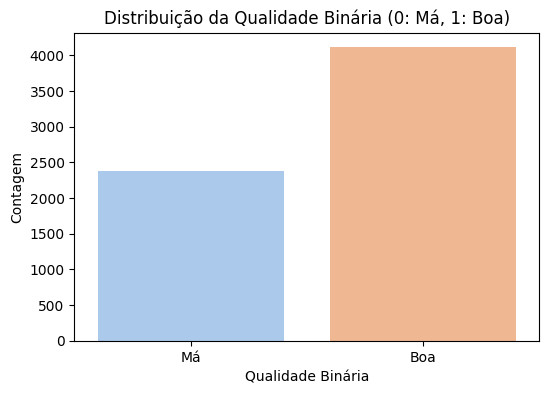

In [14]:
# --- 2.4 Criação da Variável Alvo Binária ('good_quality') ---
# Definir 'good_quality': 1 se a qualidade original for >= 6, 0 caso contrário.
df_wine['good_quality'] = df_wine['quality'].apply(lambda x: 1 if x >= 6 else 0)

print("\n--- Contagem da nova variável 'good_quality' (Após corte >= 6) ---")
print(df_wine['good_quality'].value_counts())

plt.figure(figsize=(6, 4))
sns.countplot(x='good_quality', data=df_wine, palette='pastel')
plt.title('Distribuição da Qualidade Binária (0: Má, 1: Boa)')
plt.xlabel('Qualidade Binária')
plt.ylabel('Contagem')
plt.xticks(ticks=[0, 1], labels=['Má', 'Boa'])
plt.show()

In [15]:
# --- 2.5 Aplicar One-Hot Encoding na coluna 'type' ---
df_processed_features = df_wine.copy()
df_processed_features = pd.get_dummies(df_processed_features, columns=['type'], drop_first=True, dtype=int)

print("\n--- Primeiras 5 linhas do DataFrame após One-Hot Encoding de 'type' ---")
print(df_processed_features.head())


--- Primeiras 5 linhas do DataFrame após One-Hot Encoding de 'type' ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.0              0.27         0.36            20.7      0.045   
1            6.3              0.30         0.34             1.6      0.049   
2            8.1              0.28         0.40             6.9      0.050   
3            7.2              0.23         0.32             8.5      0.058   
4            7.2              0.23         0.32             8.5      0.058   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 45.0                 170.0   1.0010  3.00       0.45   
1                 14.0                 132.0   0.9940  3.30       0.49   
2                 30.0                  97.0   0.9951  3.26       0.44   
3                 47.0                 186.0   0.9956  3.19       0.40   
4                 47.0                 186.0   0.9956  3.19       0.40   

   alcohol  q

In [16]:
# --- 2.6 Definir Features (X) e Alvo (y) (AGORA SEM ENGENHARIA DE FEATURES AVANÇADA) ---
# X conterá apenas as 11 características físico-químicas originais + 'type_white'.
features_cols_no_engineering = df_processed_features.drop(['quality', 'good_quality'], axis=1).columns

X = df_processed_features[features_cols_no_engineering].copy()
y = df_processed_features['good_quality']

print(f"\nShape das Features (X) (SEM Engenharia de Features): {X.shape}")


Shape das Features (X) (SEM Engenharia de Features): (6497, 12)


In [17]:
# --- 2.7 Escalonamento das Features (Normalização) ---
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X) # Escala X (sem as features de engenharia)
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)

print("\n--- Primeiras 5 linhas das Features Escalonadas (X_scaled_df) (SEM Engenharia de Features) ---")
print(X_scaled_df.head())
print("\n--- Média e Desvio Padrão das Features Escalonadas (devem ser próximos de 0 e 1) ---")
print(X_scaled_df.describe().loc[['mean', 'std']])


--- Primeiras 5 linhas das Features Escalonadas (X_scaled_df) (SEM Engenharia de Features) ---
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0      -0.166089         -0.423183     0.284686        3.206929  -0.314975   
1      -0.706073         -0.240949     0.147046       -0.807837  -0.200790   
2       0.682458         -0.362438     0.559966        0.306208  -0.172244   
3      -0.011808         -0.666161     0.009406        0.642523   0.056126   
4      -0.011808         -0.666161     0.009406        0.642523   0.056126   

   free sulfur dioxide  total sulfur dioxide   density        pH  sulphates  \
0             0.815565              0.959976  2.102214 -1.359049  -0.546178   
1            -0.931107              0.287618 -0.232332  0.506915  -0.277351   
2            -0.029599             -0.331660  0.134525  0.258120  -0.613385   
3             0.928254              1.243074  0.301278 -0.177272  -0.882212   
4             0.928254              1.24